In [ ]:
# Blog ImageSearch

### Download the code zip file

In [ ]:
!git clone https://github.com/salgado/image-search-01.git

fatal: destination path 'image-search-01' already exists and is not an empty directory.


### Install the necessary packages

In [ ]:
!pip -q install Pillow sentence_transformers elasticsearch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.3/409.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 94.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.4 MB/s eta 0:00:00


## Blog Post Code

### Util class

*   The `create_index()` method should
check if the index already exists before creating it. This will prevent you from accidentally overwriting an existing index.
*   The `delete_index()` method should ignore the error if the index does not exist. This is because it is normal for the index to not exist if you have not created it yet.

In [ ]:
from elasticsearch import Elasticsearch, exceptions as es_exceptions
import getpass

class Util:
    @staticmethod
    def get_index_name():
      return "dog-image-index"

    @staticmethod
    def get_connection():
        es_cloud_id = getpass.getpass('Enter Elastic Cloud ID:  ')
        es_user = getpass.getpass('Enter cluster username:  ')
        es_pass = getpass.getpass('Enter cluster password:  ')

        es = Elasticsearch(cloud_id=es_cloud_id,
                          basic_auth=(es_user, es_pass)
                          )
        es.info() # should return cluster info
        return es


    @staticmethod
    def create_index(es: Elasticsearch, index_name: str):
        # Specify index configuration
        index_config = {
          "settings": {
            "index.refresh_interval": "5s",
            "number_of_shards": 1
          },
          "mappings": {
            "properties": {
              "image_embedding": {
                "type": "dense_vector",
                "dims": 512,
                "index": True,
                "similarity": "cosine"
              },
              "dog_id": {
                "type": "keyword"
              },
              "breed": {
                "type" : "keyword"
              },
              "image_path" : {
                "type" : "keyword"
              },
              "owner_name" : {
                "type" : "keyword"
              },
              "exif" : {
                "properties" : {
                  "location": {
                    "type": "geo_point"
                  },
                  "date": {
                    "type": "date"
                  }
                }
              }
            }
          }
        }

        # Create index
        if not es.indices.exists(index=index_name):
            index_creation = es.indices.create(index=index_name, ignore=400, body=index_config)
            print("index created: ", index_creation)
        else:
            print("Index  already exists.")


    @staticmethod
    def delete_index(es: Elasticsearch, index_name: str):
        # delete index
        es.indices.delete(index=index_name, ignore_unavailable=True)



### Dog class

In [ ]:
import os
from sentence_transformers import SentenceTransformer
from PIL import Image

# domain class
class Dog:
    model = SentenceTransformer('clip-ViT-B-32')

    def __init__(self, dog_id, image_path, breed, owner_name):
        self.dog_id = dog_id
        self.image_path = image_path
        self.breed = breed
        self.image_embedding = None
        self.owner_name = owner_name

    @staticmethod
    def get_embedding(image_path: str):
        temp_image = Image.open(image_path)
        return Dog.model.encode(temp_image)

    def generate_embedding(self):
        self.image_embedding = Dog.get_embedding(self.image_path)

    def __repr__(self):
        return (f"Image(dog_id={self.dog_id}, image_path={self.image_path}, "
                f"breed={self.breed}, image_embedding={self.image_embedding}, "
                f"owner_name={self.owner_name})")

    def to_dict(self):
        return {
            'dog_id': self.dog_id,
            'image_path': self.image_path,
            'breed': self.breed,
            'image_embedding': self.image_embedding,
            'owner_name': self.owner_name
        }


### DogRepository class

In [ ]:
from typing import List, Dict
# persistence layer
class DogRepository:
    def __init__(self, es_client: Elasticsearch, index_name: str = "dog-image-index"):
        self.es_client = es_client
        self._index_name = index_name
        Util.create_index(es_client, index_name)

    def insert(self, dog: Dog):
        dog.generate_embedding()
        document = dog.__dict__
        self.es_client.index(index=self._index_name, document=document)

    def bulk_insert(self, dogs: List[Dog]):
        operations = []
        for dog in dogs:
            operations.append({"index": {"_index": self._index_name}})
            operations.append(dog.__dict__)
        self.es_client.bulk(body=operations)

    def search_by_image(self, image_embedding: List[float]):
      field_key = "image_embedding"

      knn = {
          "field": field_key,
          "k": 2,
          "num_candidates": 100,
          "query_vector": image_embedding,
          "boost": 100
      }

      # The fields to retrieve from the matching documents
      fields = ["dog_id", "breed", "owner_name","image_path", "image_embedding"]

      try:
          resp = self.es_client.search(
              index=self._index_name,
              body={
                  "knn": knn,
                  "_source": fields
              },
              size=1
          )
          # Return the search results
          return resp
      except Exception as e:
          print(f"An error occurred: {e}")
          return {}


### DogService class

In [ ]:
# service layer
class DogService:
    def __init__(self, dog_repository: DogRepository):
        self.dog_repository = dog_repository

    def register_dog(self, dog: Dog):
        self.dog_repository.insert(dog)

    def register_dogs(self, dogs: List[Dog]):
        self.dog_repository.bulk_insert(dogs)

    def find_dog_by_image(self, image_path: str):
        image_embedding = Dog.get_embedding(image_path)
        return self.dog_repository.search_by_image(image_embedding)


## The main code part 1

[### Start registering the puppies](https://)

In [ ]:
# Start a connection
es_db = Util.get_connection()
Util.delete_index(es_db, Util.get_index_name())

In [ ]:
# register one dog
dog_repo = DogRepository(es_db, Util.get_index_name())
dog_service = DogService(dog_repo)


index created:  {'acknowledged': True, 'shards_acknowledged': True, 'index': 'dog-image-index'}


<ipython-input-3-b3046747633c>:70: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
  index_creation = es.indices.create(index=index_name, ignore=400, body=index_config)


In [ ]:
from IPython.display import display
from IPython.display import Image as ShowImage


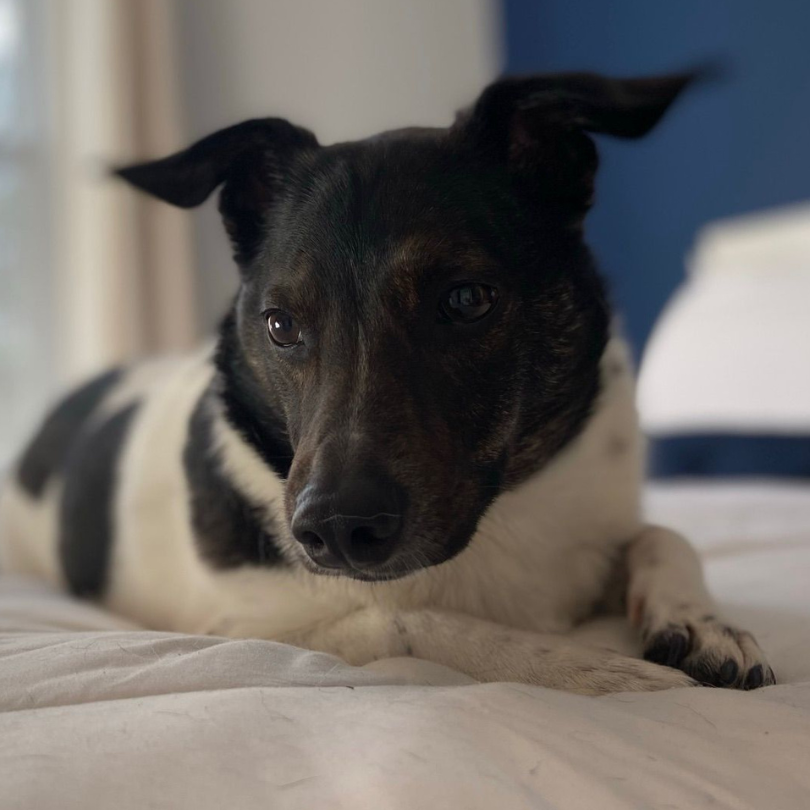

In [ ]:
filename = "/content/image-search-01/dataset/dogs/Luigi.png"
display(ShowImage(filename=filename, width=300, height=300))

### Registering Luigi

In [ ]:

dog = Dog('Luigi', filename, 'Jack Russel/Rat Terrier', 'Ully')

dog_service.register_dog(dog)


### Registering all the others puppies

> Indented block



In [ ]:
import json

# JSON data
data = '''
{
  "dogs": [
    {"dog_id": "Buddy", "image_path": "", "breed": "Labrador Retriever", "owner_name": "Berlin Red"},
    {"dog_id": "Bella", "image_path": "", "breed": "German Shepherd", "owner_name": "Tokyo Blue"},
    {"dog_id": "Charlie", "image_path": "", "breed": "Golden Retriever", "owner_name": "Paris Green"},
    {"dog_id": "Bigu", "image_path": "", "breed": "Beagle", "owner_name": "Lisbon Yellow"},
    {"dog_id": "Max", "image_path": "", "breed": "Bulldog", "owner_name": "Canberra Purple"},
    {"dog_id": "Luna", "image_path": "", "breed": "Poodle", "owner_name": "Wellington Brown"},
    {"dog_id": "Milo", "image_path": "", "breed": "Rottweiler", "owner_name": "Hanoi Orange"},
    {"dog_id": "Ruby", "image_path": "", "breed": "Boxer", "owner_name": "Ottawa Pink"},
    {"dog_id": "Oscar", "image_path": "", "breed": "Dachshund", "owner_name": "Kabul Black"},
    {"dog_id": "Zoe", "image_path": "", "breed": "Siberian Husky", "owner_name": "Cairo White"}
  ]
}
'''

# Convert JSON string to Python dictionary
dogs_data = json.loads(data)

# Traverse the list and print dog_id of each dog
image_dogs = "/content/image-search-01/dataset/dogs/"
for dog_info in dogs_data["dogs"]:
    dog = Dog(dog_info["dog_id"], image_dogs + dog_info["dog_id"] + ".png" , dog_info["breed"], dog_info["owner_name"])
    dog_service.register_dog(dog)


### Visualizing the new dogs

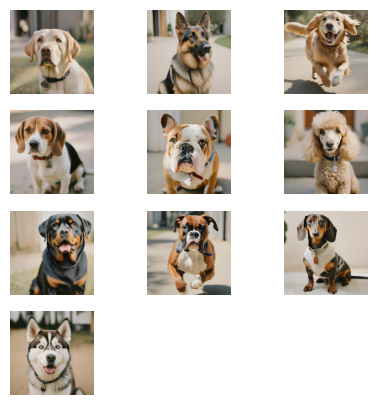

In [ ]:
# visualize new dogs
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

image_dogs = "/content/image-search-01/dataset/dogs/"
num_dogs = len(dogs_data["dogs"])

cols = int(math.sqrt(num_dogs))
rows = int(math.ceil(num_dogs / cols))

# Configurar o tamanho da figura
plt.figure(figsize=(5, 5))

# Loop para exibir as imagens dos cães
for i, dog_info in enumerate(dogs_data["dogs"]):
    filename = image_dogs + dog_info["dog_id"] + ".png"
    img = mpimg.imread(filename)

    plt.subplot(rows, cols, i+1)  # (número de linhas, número de colunas, índice do subplot)
    plt.imshow(img)
    plt.axis('off')

plt.show()


## Phase 02: Finding the lost dog

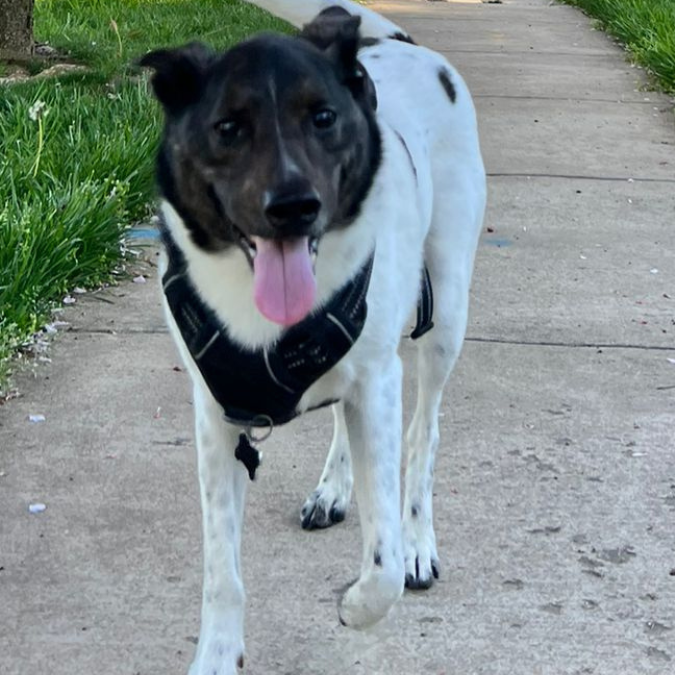

In [ ]:
filename = "/content/image-search-01/dataset/lost-dogs/lost_dog1.png"
display(ShowImage(filename=filename, width=300, height=300))

In [ ]:
# find dog by image
result = dog_service.find_dog_by_image(filename)

### Get the results

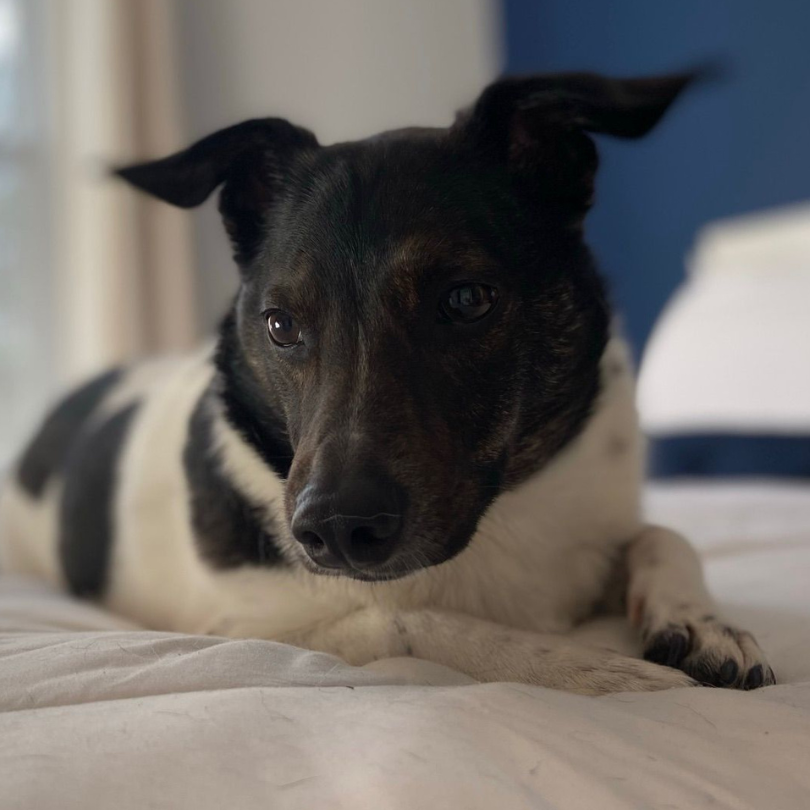

In [ ]:
filename = result['hits']['hits'][0]['_source']['image_path']
display(ShowImage(filename=filename, width=300, height=300))

### Print credentials


In [ ]:
print(result['hits']['hits'][0]['_source']['dog_id'])
print(result['hits']['hits'][0]['_source']['breed'])
print(result['hits']['hits'][0]['_source']['owner_name'])

Luigi
Jack Russel/Rat Terrier
Ully


In no time, Ully and Luigi were reunited. The little puppy wagged his tail with pure delight, and Ully hugged him close, promising to never let him out of her sight again. They had been through a whirlwind of emotions, but they were together now, and that was all that mattered. And so, with hearts full of love and joy, Ully and Luigi lived happily ever after.

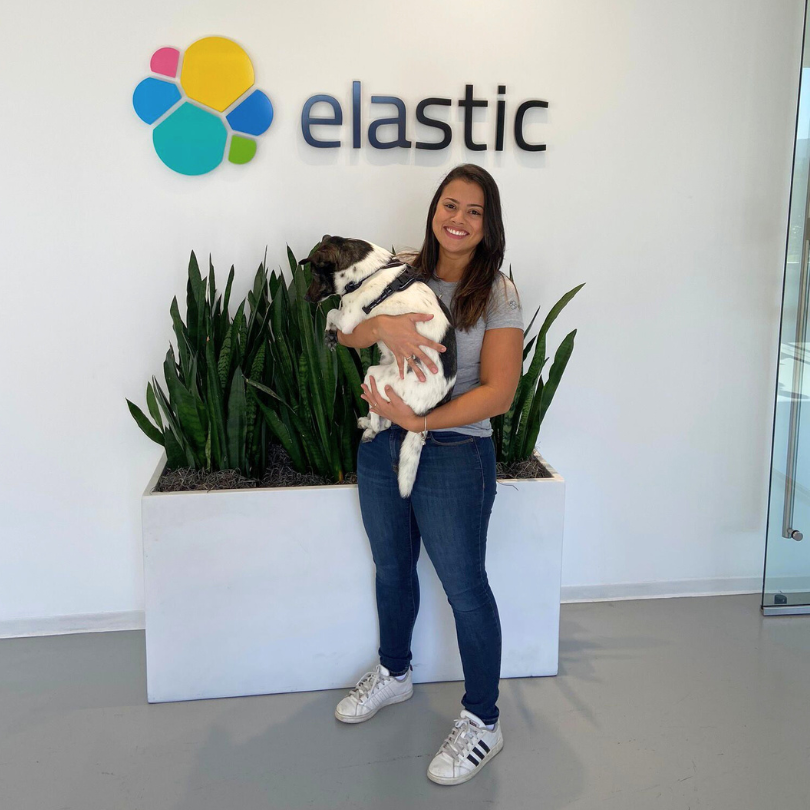

In [ ]:
filename = "/content/image-search-01/dataset/lost-dogs/Ully.png"
display(ShowImage(filename=filename, width=300, height=300))

fatal: not a git repository (or any of the parent directories): .git
